In [2]:
import pandas as pd

In [7]:
df = pd.read_feather("100k_kindle_reviews.feather")

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 4539579 to 2292238
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   overall         100000 non-null  int64 
 1   verified        100000 non-null  bool  
 2   reviewTime      100000 non-null  object
 3   reviewerID      100000 non-null  object
 4   asin            100000 non-null  object
 5   style           100000 non-null  object
 6   reviewerName    99993 non-null   object
 7   reviewText      99977 non-null   object
 8   summary         99961 non-null   object
 9   unixReviewTime  100000 non-null  int64 
 10  vote            100000 non-null  int64 
 11  image           63 non-null      object
dtypes: bool(1), int64(3), object(8)
memory usage: 9.3+ MB


In [9]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
4539579,1,True,"10 1, 2016",A326085M0DK10B,B00IA34QKO,{'Format:': ' Kindle Edition'},Crazyartdolls,This story was so short and went nowhere other...,Blah,1475280000,0,None
2317524,1,True,"05 23, 2015",A3744VUPABS7W0,B00REZMCF0,{'Format:': ' Kindle Edition'},Kindle Customer,A stuttering and lukewarm romance. A main char...,Skip it,1432339200,0,None
3569567,1,True,"03 30, 2012",A3IGQHD8E7A6HU,B001E0PW8A,{'Format:': ' Kindle Edition'},Petey440,This was an account of someone who is not only...,It was just bad.,1333065600,0,None
1561699,1,True,"12 6, 2014",A28B5ZUPE5K7UU,B00I52PPT6,{'Format:': ' Kindle Edition'},pegret,Haven't read it yet.,The same,1417824000,0,None
5193680,1,True,"06 25, 2015",A1I3GCIBVIYAZ8,B00Y26BZJS,{'Format:': ' Kindle Edition'},Tiffany S,Out of only sheer morbid curiosity I picked up...,Predictably Boring,1435190400,0,None


In [10]:
# if image is non null return 1 else 0
df['image'] = df['image'].notnull().astype('int')

replace null with empty string

In [21]:
# in review text replace null values with empty string
df['reviewText'] = df['reviewText'].fillna('')
df['summary'] = df['summary'].fillna('')

convert verfied to dummy

In [12]:
# convert verified to int 1 if true 0 if false
df['verified'] = df['verified'].astype('int')

In [14]:
df = df.drop(columns=['style'])

dropped reviewtime, already have unix representation

In [15]:
# drop the reviewTime column
df = df.drop(columns='reviewTime')

creating review length column

In [16]:
# create a new column called reviewLength
df['reviewLength'] = df['reviewText'].apply(lambda x: 0 if isinstance(x, float) else len(x))

creating summary length column

In [22]:
# create a new column called summaryLength (There were some NaN values in summary, which was forcing the type to be float64.  This ensures everything is an int).
df['summaryLength'] = df['summary'].apply(lambda x: 0 if isinstance(x, float) else len(x))

asin is the amazon product id. removing this and the reviewer info

In [23]:
# removing asin, reviewerID, reviewerName
df = df.drop(columns=['asin', 'reviewerID', 'reviewerName'])

labeling categorical variables

In [99]:
# labeling ['verified', 'image'] as categorical
df[['overall', 'verified', 'image']] = df[['overall', 'verified', 'image']].astype('category')

reviewing data

In [100]:
df.head()

,overall,verified,reviewText,summary,unixReviewTime,vote,image,reviewLength,summaryLength
4539579,1,1,This story was so short and went nowhere other...,Blah,1475280000,0,0,248,4
2317524,1,1,A stuttering and lukewarm romance. A main char...,Skip it,1432339200,0,0,158,7
3569567,1,1,This was an account of someone who is not only...,It was just bad.,1333065600,0,0,635,16
1561699,1,1,Haven't read it yet.,The same,1417824000,0,0,20,8
5193680,1,1,Out of only sheer morbid curiosity I picked up...,Predictably Boring,1435190400,0,0,527,18


## Initial Model

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 4539579 to 2292238
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   overall         100000 non-null  category
 1   verified        100000 non-null  category
 2   reviewText      100000 non-null  object  
 3   summary         100000 non-null  object  
 4   unixReviewTime  100000 non-null  int64   
 5   vote            100000 non-null  int64   
 6   image           100000 non-null  category
 7   reviewLength    100000 non-null  int64   
 8   summaryLength   100000 non-null  int64   
dtypes: category(3), int64(4), object(2)
memory usage: 5.6+ MB


In [103]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.compose import ColumnTransformer

# Step 1: Prepare the data
X = df[['verified', 'vote', 'image', 'reviewLength', 'summaryLength']]  # Your Bag-of-Words representation
y = df['overall']  # Target variable

preprocessor = ColumnTransformer(
    [
        ("scaler", StandardScaler(), ['reviewLength', 'summaryLength']),
        ("kbin", KBinsDiscretizer(encode='ordinal', n_bins=5, strategy='kmeans'), ['vote']),
    ],
    verbose_feature_names_out=False,
).set_output(transform="pandas")

X_out = preprocessor.fit_transform(X)

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_out, y, test_size=0.25, random_state=42)

/Users/andy/csc5610/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


In [104]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix


def model_calc_stats(model, X_test, y_test):
    y_predictions = model.predict(X_test)
    model_mse = mean_squared_error(y_test, y_predictions)
    model_rmse = np.sqrt(model_mse)
    model_mape = mean_absolute_percentage_error(y_test, y_predictions)
    model_residuals = (y_test - y_predictions)
    return {'name': model.__class__.__name__,'mse': model_mape, 'rmse': model_rmse, 'mape': model_mape, 'y_pred': y_predictions, 'residuals': model_residuals}

def model_print_stats(stats):
    print("{name} RMSE (MPa): {rmse:.1f}".format(name=stats['name'], rmse=stats['rmse']))
    print("{name} MAPE: {mape:.1%}".format(name=stats['name'], mape=stats['mape']))



In [108]:
# import linear regression
from sklearn.linear_model import LinearRegression
# Step 3: Train a logistic regression model
log_reg_model = LinearRegression()
log_reg_model.fit(X_train, y_train)

log_reg_stats = model_calc_stats(log_reg_model, X_test, y_test)


TypeError: Object with dtype category cannot perform the numpy op subtract

In [116]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_reg_y_test_pred = rf_model.predict(X_test)

rf_model_accuracy = rf_model.score(X_test, y_test)
print(f"Accuracy of the linear regression model: {rf_model_accuracy:.4f}")

Accuracy of the linear regression model: 0.2852


array([[1670,  909,  802,  799,  795],
       [ 887, 1472,  872,  922,  883],
       [ 786,  871, 1494,  943,  917],
       [ 814,  840,  847, 1239, 1245],
       [ 884,  839,  819, 1197, 1254]])

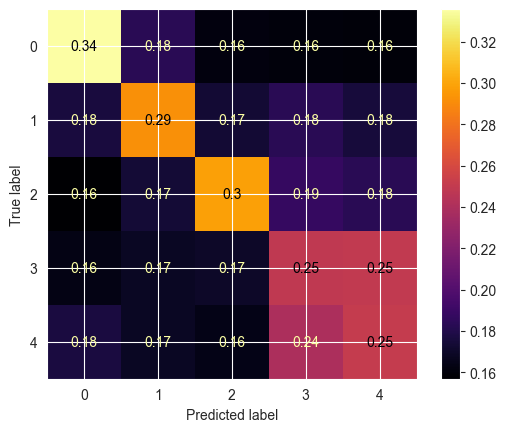

In [141]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_test, rf_reg_y_test_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='inferno')

In [142]:
cm

array([[0.33567839, 0.18271357, 0.16120603, 0.16060302, 0.15979899],
       [0.17613185, 0.29229547, 0.1731533 , 0.18308181, 0.17533757],
       [0.15685492, 0.1738176 , 0.29814408, 0.18818599, 0.18299741],
       [0.16328987, 0.16850552, 0.16990973, 0.24854564, 0.24974925],
       [0.17704787, 0.16803525, 0.16402964, 0.23973563, 0.25115161]])

In [153]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(loss='log_loss', random_state=42)
sgd = sgd.fit(X_train, y_train)


sgd.fit(X_train, y_train)
sgd_y_test_pred = sgd.predict(X_test)

sgd_model_accuracy = sgd.score(X_test, y_test)
print(f"Accuracy of the SGDClassifier model: {sgd_model_accuracy:.4f}")

Accuracy of the SGDClassifier model: 0.2182


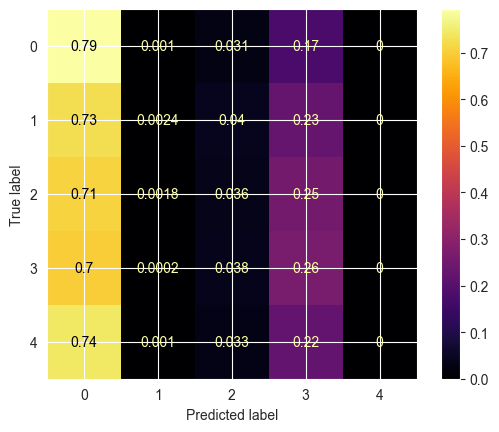

In [146]:
cm = confusion_matrix(y_test, sgd_y_test_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='inferno')

In [154]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

dtc_y_test_pred = dtc.predict(X_test)

dtc_model_accuracy = dtc.score(X_test, y_test)
print(f"Accuracy of the SGDClassifier model: {dtc_model_accuracy:.4f}")

Accuracy of the SGDClassifier model: 0.2858


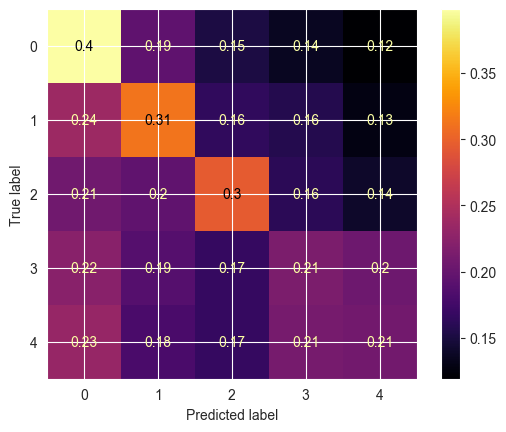

In [155]:
cm = confusion_matrix(y_test, dtc_y_test_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='inferno')